# Grover Optimizer for Quadratic Unconstrained Binary Optimization
The latest version of this notebook is available on https://github.com/Qiskit/qiskit-iqx-tutorials.

## Introduction

Grover Adaptive Search (GAS) has been explored as a possible solution for combinatorial optimization problems, alongside variational algorithms such as Variational Quantum Eigensolver (VQE) and Quantum Approximate Optimization Algorithm (QAOA). The algorithm iteratively applies Grover Search to find the optimum value of an objective function, by using the best-known value from the previous run as a threshold. The adaptive oracle used in GAS recognizes all values above or below the current threshold (for max and min respectively), decreasing the size of the search space every iteration the threshold is updated, until an optimum is found.

In this notebook we will explore each component of the `GroverOptimizer`, which utilizes the techniques described in GAS, by minimizing a Quadratic Unconstrained Binary Optimization (QUBO) problem, as described in [1]

### References

[1] [A. Gilliam, S. Woerner, C. Gonciulea, *Grover Adaptive Search for Constrained Polynomial Binary Optimization,*  arXiv  preprint arXiv:1912.04088  (2019).](https://arxiv.org/abs/1912.04088)

## Grover Adaptive Search
Grover Search, the core element of GAS, needs three ingredients:

1. A state preparation operator $A$ to construct a superposition of all states in the search space.

2. An oracle operator $O$, that recognizes the states of interest and multiplies their amplitudes by -1.

3. The Grover diffusion operator $D$, that multiplies the amplitude of the $|0\rangle_n$ state by -1.

While implementations of GAS vary around the specific use case, the general framework still loosely follows the steps described below.

<br>
<div>
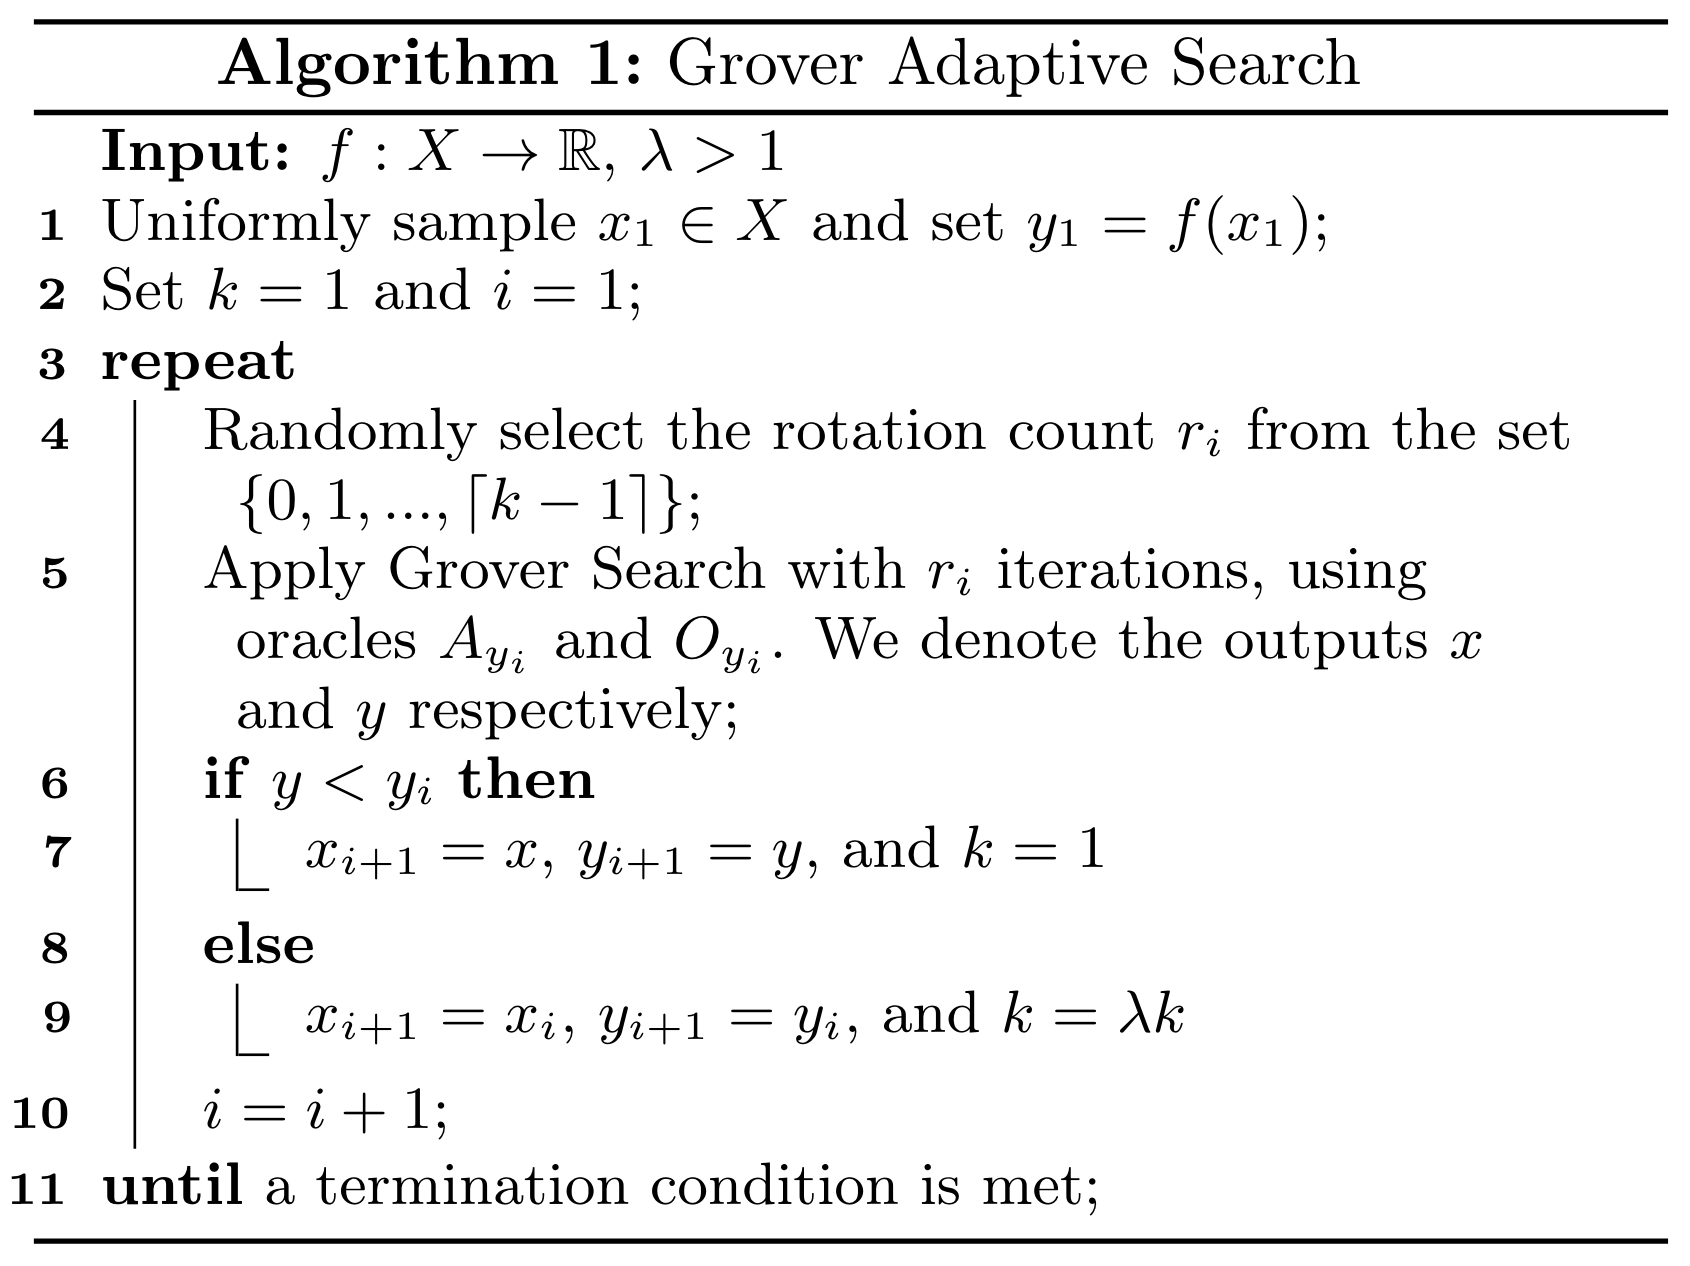
</div>
<br>

```GroverOptimizer``` uses ```QuadraticProgramToNegativeValueOracle``` to construct $A_y$ such that it prepares a $n$-qubit register to represent the equal superposition of all $|x\rangle_n$ and a $m$-qubit register to (approximately) represent the corresponding $|Q(x)-y\rangle_m$. Then, all states with $(Q(x) - y)$ negative should be flagged by $O_y$. Note that in the implementation discussed, the oracle operator is actually independent of $y$, but this is not a requirement. For clarity, we will refer to the oracle as $O$ when the oracle is independent of $y$.

Put formally, ```QuadraticProgramToNegativeValueOracle``` constructs an $A_y$ and $O$ such that:

<br>
<div>
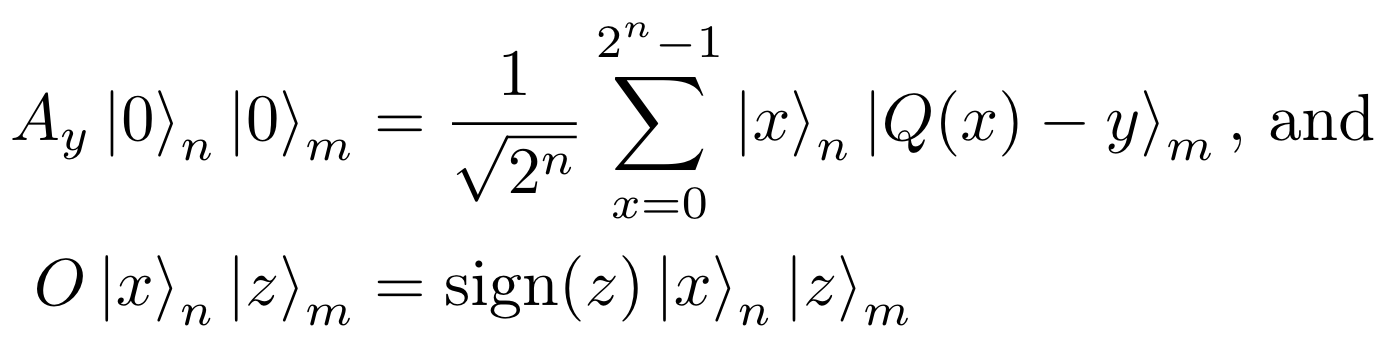
</div>
<br>

where $|x\rangle$ is the binary encoding of the integer $x$. 

At each iteration in which the threshold $y$ is updated, we adapt $A_y$ such that the function values are shifted up or down (for minimum and maxmimum respectively) by $y$. For example, in the context of finding the minimum, as the value of $y$ decreases, the search space (negative values) also decreases, until only the minimum value remains. A concrete example will be explored in the next section.

## Find the Minimum of a QUBO Problem using `GroverOptimizer`
The following is a toy example of a minimization problem.

\begin{eqnarray}
\min_{x \in \{0, 1\}^3} -2x_1x_3 - x_2x_3 - 1x_1 + 2x_2 - 3x_3.
\end{eqnarray}

For our initial steps, we create a docplex model that defines the problem above, and then use the ```from_docplex()``` function to convert the model to a ```QuadraticProgram```, which can be used to represent a QUBO in Qiskit Optimization.

In [1]:
from qiskit.aqua.algorithms import NumPyMinimumEigensolver
from qiskit.optimization.algorithms import GroverOptimizer, MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram
from qiskit import BasicAer
from docplex.mp.model import Model

backend = BasicAer.get_backend('statevector_simulator')

In [2]:
model = Model()
x0 = model.binary_var(name='x0')
x1 = model.binary_var(name='x1')
x2 = model.binary_var(name='x2')
model.minimize(-x0+2*x1-3*x2-2*x0*x2-1*x1*x2)
qp = QuadraticProgram()
qp.from_docplex(model)
print(qp.print_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model1

Minimize
 obj: - x0 + 2 x1 - 3 x2 + [ - 4 x0*x2 - 2 x1*x2 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1

Binaries
 x0 x1 x2
End



Next, we create a `GroverOptimizer` that uses 6 qubits to encode the value, and will terminate after there have been 10 iterations of GAS without progress (i.e. the value of $y$ does not change). The `solve()` function takes the `QuadraticProgram` we created earlier, and returns a results object that contains information about the run.

In [3]:
grover_optimizer = GroverOptimizer(6, num_iterations=10, quantum_instance=backend)
results = grover_optimizer.solve(qp)
print("x={}".format(results.x))
print("fval={}".format(results.fval))

x=[1.0, 0.0, 1.0]
fval=-6


This results in the optimal solution $x_0=1$, $x_1=0$, $x_2=1$ and the optimal objective value of $-6$ (most of the time, since it is a randomized algorithm).
In the following, a custom visualization of the quantum state shows a possible run of `GroverOptimizer` applied to this QUBO.

<br>
<div>
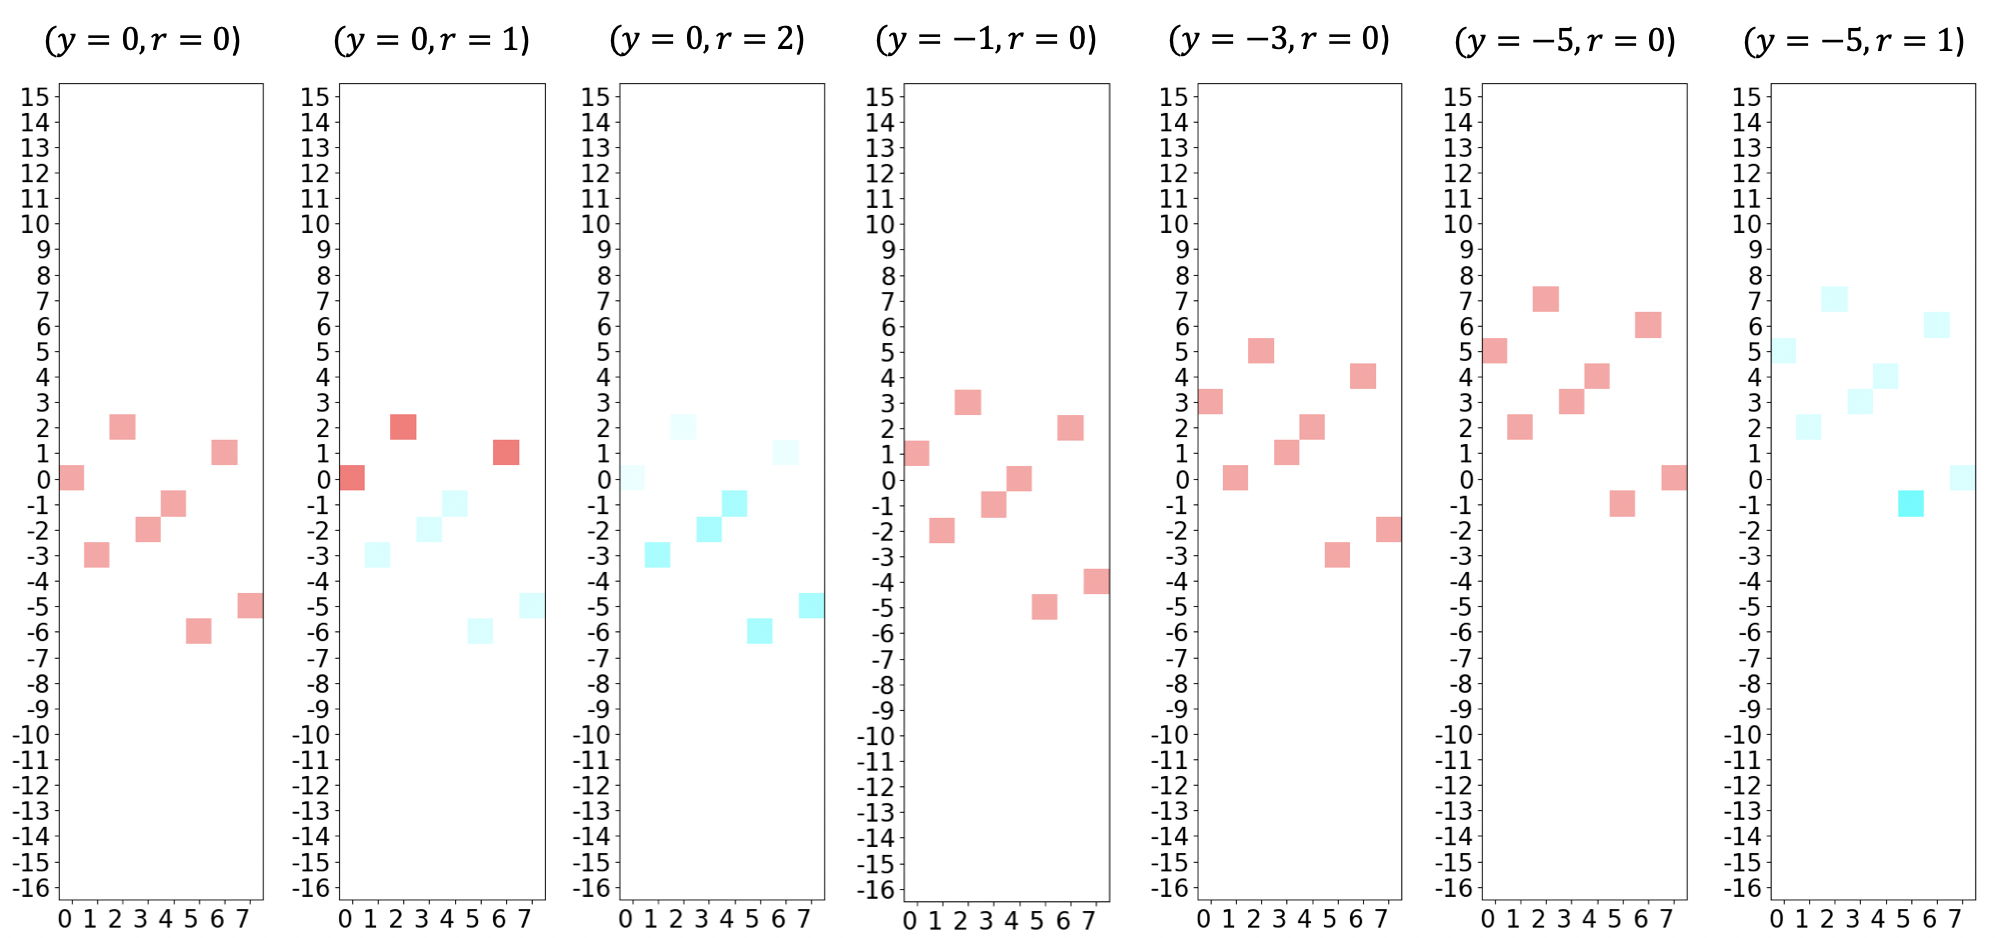
</div>
<br>

Each graph shows a single iteration of GAS, with the current values of $r$ (= iteration counter) and $y$ (= threshold/offset) shown in the title. The X-axis displays the integer equivalent of the input (e.g. '101' $\rightarrow$ 5), and the Y-axis shows the possible function values. As there are 3 binary variables, there are $2^3=8$ possible solutions, which are shown in each graph. The color intensity indicates the probability of measuring a certain result (with bright intensity being the highest), while the actual color indicates the corresponding phase (see phase diagram below). Note that as $y$ decreases, we shift all of the values up by that amount, meaning there are fewer and fewer negative values in the distribution, until only one remains (the minimum).

<br>
<div>
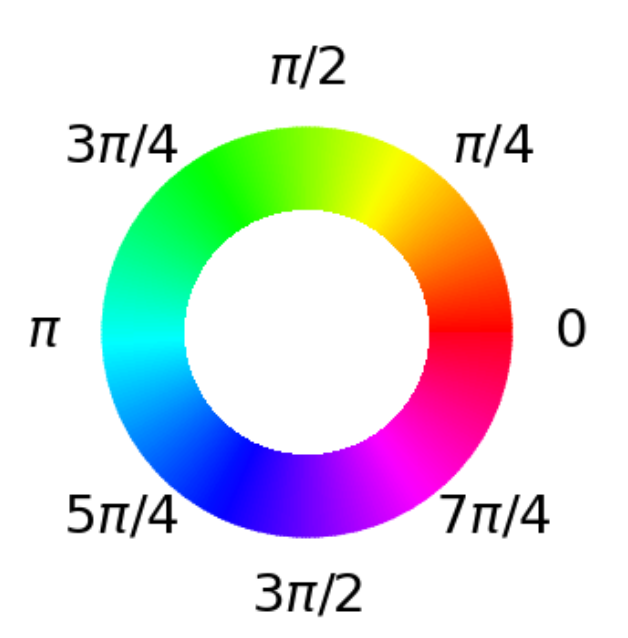
</div>

## Check that ```GroverOptimizer``` finds the correct value

We can verify that the algorithm is working correctly using the `MinimumEigenOptimizer` in Qiskit.

In [4]:
exact_solver = MinimumEigenOptimizer(NumPyMinimumEigensolver())
exact_result = exact_solver.solve(qp)
print("x={}".format(exact_result.x))
print("fval={}".format(exact_result.fval))

x=[1.0, 0.0, 1.0]
fval=-6.0


In [5]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright